In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
from contractions import contractions_dict
from string import punctuation
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)

## Create Amazon Customer Reviews DataFrame from JSON objects

In [ ]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Cell_Phones_and_Accessories_5.json.gz')

df.head()

In [ ]:
df = df.dropna(subset = ['reviewText','summary'])
df.isna().sum()

In [4]:
print(df['overall'].value_counts())
df['overall'].value_counts(normalize=True) * 100

5.0    706102
4.0    184293
3.0    98189 
1.0    81469 
2.0    57153 
Name: overall, dtype: int64


5.0    62.641789
4.0    16.349540
3.0    8.710830 
1.0    7.227517 
2.0    5.070324 
Name: overall, dtype: float64

## Separate positive and negative reviews for analysis

In [ ]:
df_negative_reviews = df[df['overall']<3].iloc[:100000]
df_positive_reviews = df[df['overall']>3].iloc[:200000]

In [ ]:
df_new = df.iloc[:100]
df_new.head()

## Review Text PreProcssing Function Definitions

In [5]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [6]:
from nltk.tokenize import RegexpTokenizer
def cleanme(txt):
    sent = txt.lower()
    sent_expanded_contractions = expand_contractions(sent,contractions_dict)
    sent_expanded_contractions = re.sub(r'(?<=[.,])(?=[^\s])', r' ', sent_expanded_contractions)
    sent_without_punct = strip_punctuation(sent_expanded_contractions)
    sent_without_digits=re.sub('[0-9]+', '', sent_without_punct)
    
    TOKENIZER = RegexpTokenizer('(?u)\W+|\$[\d\.]+|\S+')
#     wrds = TOKENIZER.tokenize(sent_without_punct)
    wrds = word_tokenize(sent_without_digits)
    to_remove = ['no', 'not']
    new_stopwords = set(stopwords.words('english')).difference(to_remove)
    clwrds = [w for w in wrds if not w in new_stopwords]
    ln = len(clwrds)
    if ln>0:
        pos = pd.DataFrame(pos_tag(wrds))
        pos = (" ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))).split(" ")
        l2 = ["i","you","me"]
        pos = [x for x in pos if x not in l2]
    else:
        pos = [""]
    rt = [ln, " ".join(clwrds), " ".join(pos)]
    return(rt)

## Create Negative Reviews WordCloud

In [ ]:
tmp = list()
for i in range(100000):
    tmp.append(cleanme(df_negative_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_negative_reviews_new = df_negative_reviews.reset_index()
# df_negative_reviews_new.drop(['reviewlen', 'cleanrev', 'adjreview'], axis=1, inplace=True)
df_negative_reviews_new = pd.concat([df_negative_reviews_new,tmp], axis=1)
df_negative_reviews_new = df_negative_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_negative_reviews_new.head()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_negative_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
# stemmed_word = [snowball_stemmer.stem(word) for word in words]
bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(40)

In [ ]:
d = {}
for key, value in fdist.items() :
#     print ("_".join(key), value)
    d["_".join(key)] = value

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Bigrams_frequent_words.png")

## Create Positive Reviews WordCloud

In [ ]:
tmp = list()
for i in range(150000):
    tmp.append(cleanme(df_positive_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_positive_reviews_new = df_positive_reviews.reset_index()
df_positive_reviews_new = pd.concat([df_positive_reviews_new,tmp], axis=1)
df_positive_reviews_new = df_positive_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_positive_reviews_new.head()

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_positive_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
# stemmed_word = [snowball_stemmer.stem(word) for word in words]

bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(30)

In [ ]:
d = {}
for key, value in fdist.items() :
#     print ("_".join(key), value)
    d["_".join(key)] = value

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Positive_Reviews.png")

## PreProcess 200K reviews to be used to build classification models

In [28]:
df_new = df.iloc[:200000]

tmp = list()
for i in range(200000):
    tmp.append(cleanme(df_new.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_new = df_new.reset_index()
# df_negative_reviews_new.drop(['reviewlen', 'cleanrev', 'adjreview'], axis=1, inplace=True)
df_new = pd.concat([df_new,tmp], axis=1)
df_new = df_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs


In [159]:
df_new.columns = ['overall','reviewText','summary','cleanReviewLength', 'cleanReview', 'adjectives']
df_new.head()

,overall_rating,reviewText,summary,cleanReviewLength,cleanReview,adjectives,polarity
0,5.0,"Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.",Can't stop won't stop looking at it,23,looks even better person careful not drop phone often rhinestones fall duh decorative case protective say fits perfectly securely phone overall pleased purchase,careful more decorative protective overall pleased,0.331250
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great,0.600000
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable,-0.004167
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,,0.200000
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs,0.511111


## Calculate Polarity of Reviews

In [130]:
from textblob import TextBlob, Word
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

df_new['polarity'] = df_new.reviewText.apply(detect_polarity)
df_new[1:10]

,overall_rating,reviewText,summary,cleanReviewLength,cleanReview,adjectives,polarity
1,5.0,When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!,1,11,not want spend whole lot cash want great deal shop buy,whole great,0.600000
2,3.0,"so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far",Its okay,24,case came time love design actually missing studs nothing noticeable studding almost bit sloppy around bow not noticeable not put phone yet notice far,noticeable sloppy noticeable,-0.004167
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT. JUST NOT WHAT I EXPECTED.,CASE,7,not care gave gift okay not expected,,0.200000
4,4.0,"I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.",Cute!,13,liked cute studs fall easily protect phone would not recommended buy like looks,cute studs,0.511111
5,2.0,The product looked exactly like the picture and it was very nice. However only days later it fell apart. I'm very disappointed with the quality of the product.,Not so happy,14,product looked exactly like picture nice however days later fell apart disappointed quality product,nice disappointed,0.011000
6,3.0,I FINALLY got my case today. It took forever to get here! It's cute and looks just like the pic. Like right after I wrote this review some of the rhinestones started falling off. The package does come with glue to glue them back on but in my opinion this case is only good for a couple of days (if that.) I wouldn't purchase another. Thanks you,It's cute!,33,finally got case today took forever get cute looks like pic like right wrote review rhinestones started falling package come glue glue back opinion case good couple days would not purchase another thanks,cute good,0.240816
7,5.0,"It is a very cute case. None of the jewels have fallen off and the bow is glued on very well. Came in the time frame that was given and I'm happy with this purchase. The only thing you might want to know is, I carry my phone in my jeans and it does fit very tightly because it is a big bow. You have to be careful but worth it.",Cute case,27,cute case none jewels fallen bow glued well came time frame given happy purchase thing might want know carry phone jeans fit tightly big bow careful worth,cute happy only fit big careful worth,0.224206
8,1.0,DO NOT BUY! this item is seriously cheap as heck. not worth buying it at all. I didn't even get to use it and it was already losing all of its gems. I wish I got my money back on this item!!,WORST ITEM!,21,not buy item seriously cheap heck not worth buying not even get use already losing gems wish got money back item,cheap worth wish,0.083333
9,4.0,"I really love this case... you have to keep your phone face down all the time, but it's pretty good quality. Some stones come off from normal use, unless you keep it in your purse all day.",Pretty Cute!,18,really love case keep phone face time pretty good quality stones come normal use unless keep purse day,good normal,0.288889


## Naive Bayes Multi-Class Classifier

In [101]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import sparse

tfidf = TfidfVectorizer(sublinear_tf=False, max_features = 10000, min_df=5,max_df=0.60,ngram_range= (1,2))

((40000, 6), (10000, 6))

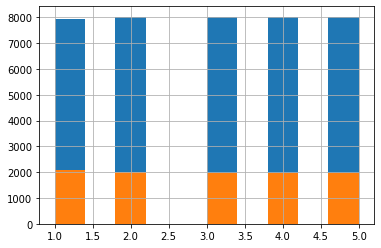

In [102]:

review_df = pd.concat([df_new[df_new['overall']==1.0].sample(n=10000),df_new[df_new['overall']==2.0].sample(n=10000),
                    df_new[df_new['overall']==3.0].sample(n=10000),df_new[df_new['overall']==4.0].sample(n=10000),
                    df_new[df_new['overall']==5.0].sample(n=10000)])
review_df = review_df[['cleanReview','overall']]
train, test = train_test_split(review_df, test_size=0.2)

train['overall'].hist();
test['overall'].hist();

train = pd.get_dummies(train, columns = ['overall'])
train.head()

test = pd.get_dummies(test, columns = ['overall'])
test.head()

train.shape, test.shape


In [103]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [104]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [105]:
class_names = ['overall_1.0', 'overall_2.0','overall_3.0','overall_4.0','overall_5.0']
scores = []
preds = np.zeros((len(test), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train['cleanReview'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train['cleanReview'].values, train_target)
    preds[:,i] = p.predict_proba(test['cleanReview'].values)[:,1]

CV score for class overall_1.0 is 0.8514749991893641
CV score for class overall_2.0 is 0.7940000678658036
CV score for class overall_3.0 is 0.7977499722478812
CV score for class overall_4.0 is 0.8018499997523186
CV score for class overall_5.0 is 0.8517000160642234


In [106]:
t = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.57      0.64      0.60      2071
           1       0.40      0.37      0.38      1995
           2       0.38      0.34      0.36      1983
           3       0.44      0.40      0.42      1980
           4       0.57      0.67      0.62      1971

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.48     10000
weighted avg       0.47      0.48      0.48     10000



## Some Analysis

5.0    115702
4.0    36215 
3.0    20788 
1.0    15830 
2.0    11465 
Name: overall_rating, dtype: int64


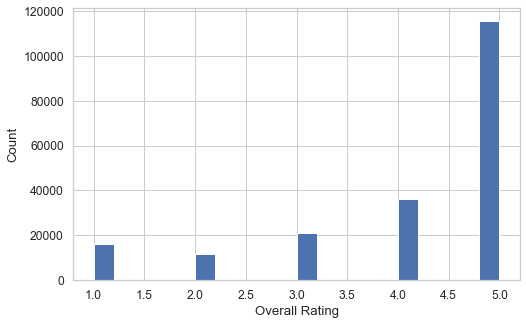

In [186]:
df_new=df_new.rename(columns = {'overall':'overall_rating'})
print(df_new['overall_rating'].value_counts())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    (df_new['overall_rating']), norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Overall Rating', ylabel='Count');

   overall_rating  cleanReviewLength
0  1.0             30.522091        
1  2.0             37.586418        
2  3.0             34.564620        
3  4.0             38.774612        
4  5.0             25.417610        
   overall_rating  polarity
0  1.0             0.009891
1  2.0             0.097770
2  3.0             0.188911
3  4.0             0.272849
4  5.0             0.388435


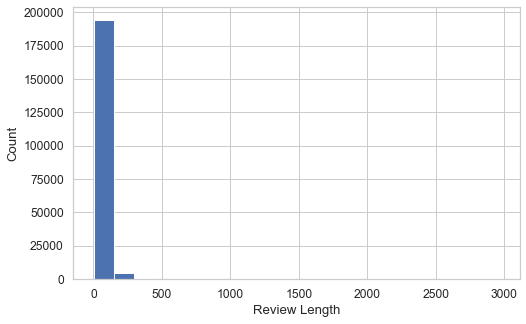

In [187]:
df_res = df_new[df_new['cleanReviewLength']>0]
print(df_res.groupby('overall_rating', as_index=False)['cleanReviewLength'].mean())
print(df_res.groupby('overall_rating', as_index=False)['polarity'].mean())

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    (df_res['cleanReviewLength']), norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Review Length', ylabel='Count');

## Some Other Multi-Class Classifier Models which also takes into account Review Length and Polarity

In [188]:
df_res = pd.concat([df_new[df_new['overall_rating']==1.0].sample(n=10000),df_new[df_new['overall_rating']==2.0].sample(n=10000),
                    df_new[df_new['overall_rating']==3.0].sample(n=10000),df_new[df_new['overall_rating']==4.0].sample(n=10000),
                    df_new[df_new['overall_rating']==5.0].sample(n=10000)])
df_res = df_res[df_res['cleanReviewLength']<50]
df_res['overall_rating'].value_counts()

5.0    8856
1.0    8497
3.0    8122
4.0    7992
2.0    7927
Name: overall_rating, dtype: int64

In [189]:


df_100 = df_res.copy()

v = TfidfVectorizer(max_features = 10000, min_df=5,max_df=0.60)
x = v.fit_transform(df_100['cleanReview'])


df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
df_100 = df_100.drop('cleanReview', axis=1)

df_100.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)
# print(df_100)
res = pd.concat([df_100, df1], axis=1)


In [193]:
res1 = res[res.columns.difference(['reviewText','summary', 'adjectives', 'overall_rating'])]
normalized_res1 = res1
normalized_res1['cleanReviewLength']= (normalized_res1['cleanReviewLength']-normalized_res1['cleanReviewLength'].min())/(normalized_res1['cleanReviewLength'].max()-normalized_res1['cleanReviewLength'].min())
normalized_res1['polarity']= (normalized_res1['polarity']-normalized_res1['polarity'].min())/(normalized_res1['polarity'].max()-normalized_res1['polarity'].min())
# normalized_res1=(res1-res1.min())/(res1.max()-res1.min())
# print(normalized_res1.head(100))
y = res['overall_rating'].values.reshape(-1,1)

res1.shape, y.shape

# y = res['rating']
# len(y)

((41394, 5670), (41394, 1))

## Logistic Regression Classifier

Multinomial Logistic regression Train Accuracy ::  0.6179374905631889
Multinomial Logistic regression Test Accuracy ::  0.4860490397390989


Text(0.5, 257.44, 'Predicted label')

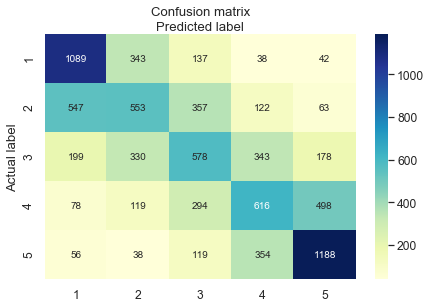

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state= 51)
lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train,y_train)

print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, lr.predict(X_test))


class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## KNN Classifier

0.31576402321083175


Text(0.5, 257.44, 'Predicted label')

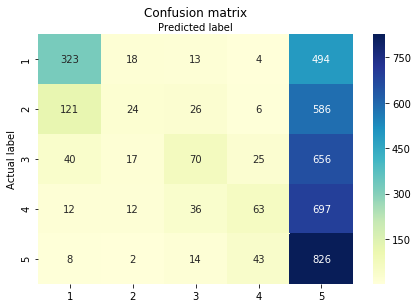

In [155]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2,random_state=51)
knn = KNeighborsClassifier(n_neighbors = 100).fit(X_train, y_train)

accuracy = knn.score(X_test, y_test) 
print (accuracy)
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cnf_matrix = metrics.confusion_matrix(y_test, knn_predictions) 

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## SVM Linear Classifier

Multinomial SVM Train Accuracy ::  0.6658915899139363
Multinomial SVM Test Accuracy ::  0.4666022466481459


Text(0.5, 257.44, 'Predicted label')

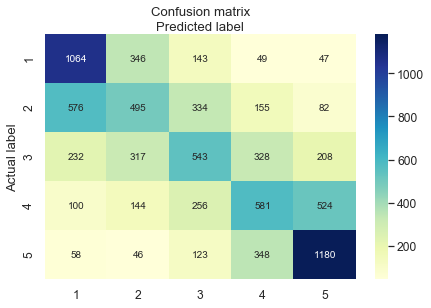

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state=51)
svm = LinearSVC()
svm.fit(X_train,y_train)

print ("Multinomial SVM Train Accuracy :: ", metrics.accuracy_score(y_train, svm.predict(X_train)))
print ("Multinomial SVM Test Accuracy :: ", metrics.accuracy_score(y_test, svm.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, svm.predict(X_test))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Multinomial Multinomial Naive Bayes Train Accuracy ::  0.58936
Multinomial Multinomial Naive Bayes Accuracy ::  0.59168


Text(0.5, 257.44, 'Predicted label')

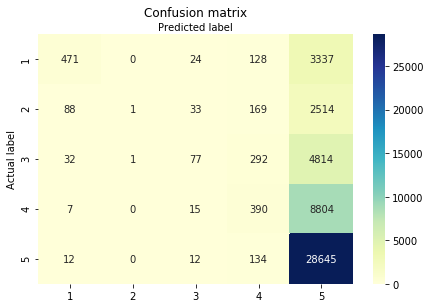

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df_new['cleanReview'], df_new['overall_rating'], random_state = 101)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
print ("Multinomial Multinomial Naive Bayes Train Accuracy :: ", metrics.accuracy_score(y_train, clf.predict(X_train_tfidf)))
print ("Multinomial Multinomial Naive Bayes Accuracy :: ", metrics.accuracy_score(y_test, clf.predict(count_vect.transform(X_test))))

cnf_matrix = metrics.confusion_matrix(y_test, clf.predict(count_vect.transform(X_test)))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')